# Conductor-like polarizable continuum model
The *conductor-like polarizable continuum model* (C-PCM) {cite}`Barone1998`---identical to the conductor-like screening model (COSMO) only in its original implementation---is one of the most widely used solvation models, offering reasonable accuracy at low computational cost. C-PCM belongs to the class of apparent surface charge models, which all have in common that the solvent effect---and thus the electrostatic environment---is represented by charges on the surface of a cavity enclosing the solute. 

In C-PCM, the region inside the cavity is treated as vacuum, while the surrounding solvent is characterized by a dielectric constant $\varepsilon_\text{pol}$. The cavity is constructed from interlocking atom-centred spheres, one per atom, whose union defines the molecular cavity enclosing the solute (see figure below). In this way, only the portion of each atom-centered sphere that is exposed to the solvent contributes to the total cavity surface, $\Gamma$, ensuring that each surface point is uniquely associated with a single atom.

```{figure} ../../img/env/cavity_volume.png
---
name: cavity volume
align: center
---
Sketch of the cavity. The black dots represent the nuclei.
```

## Cavity grid
To solve the C-PCM equations for general molecules and cavity geometries, the cavity surface is discretized. We use a Lebedev quadrature scheme, to assign grid points $k$, with associated weights $w_k$, to the surface of a sphere which enables the numerical integration of a function $f$, over the surface, as

\begin{equation*} \int_0^{2 \pi} \hspace{-2.5mm} \int_0^\pi f(\theta, \varphi) \sin{\theta} \mathrm{d} \theta  \mathrm{d} \varphi \approx 4 \pi \sum_k^N w_k f(\theta_k, \varphi_k) \end{equation*}

Each grid point represents a small patch of the spherical surface, within which the quadrature effectively assumes the function to be constant. This is why a finer grid---comprising smaller surface elements---leads to more accurate results.

To begin our study of the C-PCM model, we define our solute (here a water molecule), and construct the cavity surface grid using the `CpcmDriver` available in VeloxChem.

In [1]:
import veloxchem as vlx
from veloxchem import bohr_in_angstrom
import numpy as np
np.set_printoptions(precision=3, suppress=False, formatter={'float_kind': '{:.3e}'.format})
import scipy
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
try:
    import py3Dmol as p3d
except:
    print('py3Dmol required to visualize the grid!')


In [2]:
water_xyz = """3
C2v
O    0.000000000000        0.000000000000        0.000000000000
H    0.000000000000        0.740848095288        0.582094932012
H    0.000000000000       -0.740848095288        0.582094932012
"""

molecule = vlx.Molecule.read_xyz_string(water_xyz)
cpcm_drv = vlx.CpcmDriver()

# non-hydrogen atoms
grid_per_sphere          = 194
# for hydrogen atoms
grid_per_sphere_h        = grid_per_sphere 
cpcm_drv.grid_per_sphere = [grid_per_sphere, grid_per_sphere_h]

grid, sw_f = cpcm_drv.generate_cpcm_grid(molecule)
print(f'Available grid levels: {[key for key in cpcm_drv.get_zeta_dict().keys()]}')

Available grid levels: [50, 110, 194, 302, 434, 590, 770, 974, 2030]


Grid levels are given as the number of points per atom of each sphere, corresponding to $N$ in the equation above. Unless specified otherwise through the `cpcm_drv.grid_per_sphere` attribute, the standard number of points is 194 for non-hydrogen elements, while for hydrogen typically a smaller number is used. Try varying `grid_per_sphere` and re-run the visualization below. We will soon get to the other return object from the grid method, `sw_f`. We can visualize the grid by using another class method.

In [3]:
cpcm_drv.visualize_cpcm_grid(molecule, grid)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Note that each sphere radius is determined by the element’s van der Waals (vDW) radius, making the oxygen sphere the largest and the dominant contributor to the total surface area.

We can define a function to visualize the full atomic spheres, as opposed to the clipped ones used in the actual grid construction.

In [4]:
from veloxchem.veloxchemlib import gen_lebedev_grid

def raw_grid(molecule, grid_per_sphere, scaling_factor=1.2):
    cpcm_drv.grid_per_sphere = grid_per_sphere
    unit_grid = gen_lebedev_grid(grid_per_sphere)
    unit_grid_coords = unit_grid[:, :3]
    unit_grid_weights = unit_grid[:, 3:]
    unit_grid_weights *= 4 * np.pi

    zeta = cpcm_drv.get_zeta_dict()[grid_per_sphere]
    atom_coords = molecule.get_coordinates_in_bohr()
    atom_radii = molecule.vdw_radii_to_numpy() * scaling_factor

    cpcm_grid_raw = np.zeros((0, 6))

    for i in range(molecule.number_of_atoms()):
        # scale and shift unit grid
        atom_grid_coords = unit_grid_coords * atom_radii[i] + atom_coords[i]
        grid_zeta = zeta / (atom_radii[i] * np.sqrt(unit_grid_weights))
        atom_idx = np.full_like(grid_zeta, i)
        atom_grid = np.hstack(
            (atom_grid_coords, unit_grid_weights, grid_zeta, atom_idx))
        cpcm_grid_raw = np.vstack((cpcm_grid_raw, atom_grid))

    sw_func_raw = cpcm_drv.get_switching_function(atom_coords, atom_radii, cpcm_grid_raw)
    sw_mask = (sw_func_raw > 1.0e-8)

    return cpcm_grid_raw, sw_func_raw

In [5]:
full_grid, full_sw_f = raw_grid(molecule, grid_per_sphere)
cpcm_drv.visualize_cpcm_grid(molecule, full_grid)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

As expected, by comparing to the previous figure, the points within the cavity volume are those removed, and the regions where grid points cluster densely correspond to intersections between neighbouring spheres.

There are three main issues with this grid construction:
1. Crevices may form, allowing surface charges to come unnaturally close to the solute---unnatural in the sense that the continuum is meant to represent surrounding solvent molecules, which themselves occupy physical volume and should not fit into such crevices;
2. Intersecting surface regions bring charges *very* close together, especially after resolving issue 3 via the use of a switching function, which can lead to diverging Coulomb interactions;
3. Perturbing an atomic position of the molecule (e.g., during  nuclear derivative calculations) can change the *number* of surface points---and hence the number of charges---discontinuously, resulting in a discontinuous potential energy surface.

Let us tackle each point one at a time.

1: A common solution to the first issue is to uniformly scale the (VDW) radii by a constant factor, typically 1.2. Increasing the scaling factor smooths the cavity surface, which gradually approaches the shape of a sphere in the limit. A 20% increase is usually sufficient to eliminate these pathological cases. 

Try varying the scaling factor below.

In [6]:
# standard: scaling_factor = 1.2
scaling_factor = 0.6
full_grid, full_sw_f = raw_grid(molecule, grid_per_sphere, scaling_factor=scaling_factor)
cpcm_drv.visualize_cpcm_grid(molecule, full_grid)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

2: The second issue can also be addressed quite simply; rather than describing each surface grid charge as a point charge, one can instead use spherical Gaussians. This is done by introducing a Gaussian basis $\chi_k$ at each surface charge $q_k$, effectively smearing the charge into a normalized density $g_k$ (keeping the total charge fixed, *i.e.*, $\int g_k \text{d}^3 r = q_k$), centered at $\mathbf{s}_k$, 
\begin{equation*}
    \displaystyle g_k(r) = q_k \chi_k(r) = q_k \left( \frac{\zeta_k^2}{\pi} \right)^{3/2} e^{-\zeta_k^2 |\mathbf{r} - \mathbf{s}_k|^2}
\end{equation*}
where each point is assigned a width parameter 
\begin{equation*}
\displaystyle \zeta_k = \frac{\zeta}{R_k \sqrt{w_k}}
\end{equation*}
that is naturally related to the quadrature weight $w_k$. Note that as the width goes to zero we approach the point charge description. The parameter $\zeta$ is optimized for each Lebedev quadrature level. With this representation, Coulomb interactions become *screened*---approaching a constant value for small separations---thereby resolving the divergence problem in intersecting regions.

3: For the third issue, consider a specific grid point $j \in \Gamma_J$, where $\Gamma_J \subset \Gamma$ is the portion of the cavity surface associated with atom $J$. When atom $J$ is perturbed, the corresponding surface $\Gamma_J$, and so grid point $j$, is also displaced. After the perturbation, it might be that point $j$ winds up inside a neighbouring atomic sphere. In that case, it is no longer part of the cavity surface and so no longer represent a surface charge -- it is effectively turned off (see figure below). The problem is that both the total cavity surface and the electrostatic energy, which depends on interactions with these grid points, become discontinuous functions of the nuclear coordinates.

```{figure} ../../img/env/cavity_perturb.png
---
name: cavity perturbation
align: center
---
Two-dimensional slice of a diatomic molecule.
```

Ideally, the switching on/off of surface points should be a smooth function of the nuclear coordinates. A switching function $F_k$ is introduced for each grid point $k$, with $0 \leq F_k \leq 1$ indicating whether it is on, off, or---crucially---*partially* on.

The switching function must account for all atoms in the molecule -- except the one to which the grid point is inherently associated, since it is, by definition, always on that atom's surface. To achieve this, the switching function $F_k$ is constructed as a product of elementary switching functions $f$, taken over all atoms:

\begin{equation*} F_k = \prod_{J, k \notin J}^{\text{atoms}} f(\mathbf{s}_k, \mathbf{R}_J) \end{equation*}

The position of atom $J$ is denoted $\mathbf{R}_J$, and the elementary switching function satisfies $0 \leq f(\mathbf{s}_k, \mathbf{R}_J) \leq 1$. The idea behind the elementary switching function $f$ is to exploit the spatial extent of the Gaussian surface charges. This is done by computing the fraction of normalized charge that lies inside the sphere of atom $J$---which is preciesly the quantity in curly braces in the following expression:

\begin{equation*} f(\mathbf{s}_k, \mathbf{R}_J) =  1 - \frac{1}{2} \left\{ \text{erf} (\zeta_{k} [ R_J + |\mathbf{R}_J - \mathbf{s}_k |) + \text{erf} (\zeta_{k} [ R_J - |\mathbf{R}_J - \mathbf{s}_k|) \right\} \end{equation*}

Using the function below, one can see the switching function value of each grid point.

In [7]:
def visualize_cpcm_grid(molecule, grid, sw_f, colorbar=False):
    """
    Visualizes grid for surface discretization.

    :param molecule:
        The molecule.
    :param grid:
        The grid.
    """
    
    grid_in_angstrom = grid[:, :3] * bohr_in_angstrom()
    v = p3d.view(width=600, height=600)

    v.addModel(molecule.get_xyz_string(), 'xyz')
    v.setStyle({'stick': {}})
    cmap = plt.get_cmap('viridis')

    for k in range(grid_in_angstrom.shape[0]):
        x, y, z = grid_in_angstrom[k, :3]

        color = mcolors.to_hex(cmap(sw_f[k]))
        v.addSphere({
            'center': {'x': x, 'y': y, 'z': z},
            'radius': 0.05,
            'color': color,
            'opacity': 0.6
        })

    v.zoomTo()
    v.show()
    if colorbar:
        fig, ax = plt.subplots(figsize=(6, 1))
        fig.subplots_adjust(bottom=0.5)
    
        sm = plt.cm.ScalarMappable(cmap=cmap)
        cb = plt.colorbar(sm, cax=ax, orientation='horizontal')
        cb.set_label('Switching-function value')
        plt.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

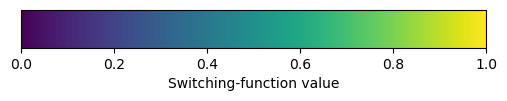

In [8]:
gps = 194
full_grid, full_sw_f = raw_grid(molecule, gps)

visualize_cpcm_grid(molecule, full_grid, full_sw_f, colorbar=True)

With the function defined below, one can observe how the switching function values of the grid points changes as one of the bonds is stretched/contracted by selecting a value from the drop-down menu below. The standard bond length is 1.0 (100%). Note: `ipywidgets` is required, so if the import fails, then it must be installed, and if the widget just shows up as some text, e.g., `display(widgets.IntSlider())
IntSlider(value=0)` after importing ipywidgets, try refreshing the browser.

In [9]:
try:
    import ipywidgets as widgets
    from IPython.display import display
except:
    print('ipywidgets required for this part!')
    
def visualize_grid_for_shifted_mols(bond_sep):
    O_xyz = (0.0, 0.0, 0.0)
    H1_xyz = (0.0, 0.740848095288, 0.582094932012)
    H2_ref = (0.0, -0.740848095288, 0.582094932012)

    def update(shift=1.0):
        H1_shifted = (H1_xyz[0],
                      H1_xyz[1]*shift,
                      H1_xyz[2]*shift)

        xyz_str = f"""3

        O  {O_xyz[0]:.6f}  {O_xyz[1]:.6f}  {O_xyz[2]:.6f}
        H  {H1_shifted[0]:.6f}  {H1_shifted[1]:.6f}  {H1_shifted[2]:.6f}
        H  {H2_ref[0]:.6f}  {H2_ref[1]:.6f}  {H2_ref[2]:.6f}
        """

        molecule_shifted = vlx.Molecule.read_xyz_string(xyz_str)
        full_grid, full_sw_f = raw_grid(molecule_shifted, grid_per_sphere)
        
        visualize_cpcm_grid(molecule_shifted, full_grid, full_sw_f, colorbar=False)

    shift_slider = widgets.Dropdown(
    options=[(f"{val:.2f}", val) for val in bond_sep],
    description="Bond scaling",
    value=1
    )

    out1 = widgets.VBox([shift_slider])
    out2 = widgets.interactive_output(update, {"shift": shift_slider})
    
    display(out1, out2)

In [10]:
# Note that for too large or too small bond distances, the separated atom is not
# displayed explicitly but the grid is still visualised correctly
# Note also that an active notebook is required for the drop-down menu to update the figure

# 1.0 corresponds to equilibrium
bond_distances = np.linspace(0.5, 2.1, 8)
bond_distances = [.5, .75, 1, 1.25, 1.5, 2]
visualize_grid_for_shifted_mols(bond_distances)

Output()

With the switching function, we have fixed the third issue as well, and these factors are taken into account in the grid-generating method of `CpcmDriver`. What we now need is a way to determine the charges on the surface.

## C-PCM equations

As the name of the model suggests, it is based on a conductor. The defining characteristic of a *perfect* conductor is that the electric field and charge density within is zero, which implies a constant electric potential on the surface. In C-PCM, the polarizable medium is approximated by a scaled perfect conductor carrying only an induced surface charge. Hence, the C-PCM equations enforce a conductor-like (scaled) boundary condition of vanishing potential on the cavity surface,

\begin{equation*} \mathbf{Aq} = -f(\varepsilon) \mathbf{v} \end{equation*}

Here $\mathbf{q}$ is the vector of induced polarization charges on the surface, $\mathbf{A}$ describes the (screened) Coulomb interaction between the charges $\mathbf{q}$, $\mathbf{v}$ is the potential due to the solute on the cavity surface, and $f(\varepsilon) = (\varepsilon - 1) / \varepsilon$ is the scaling function that reduces the induced charges as to reflect a dielectric of finite permittivity $\varepsilon$. Note that for a perfect conductor we have $\varepsilon \rightarrow \infty: f(\varepsilon) \rightarrow 1$ and the equation reduces to the normal conductor boundary condition: $\mathbf{Aq + v} = 0$. The solute potential $\mathbf{v}$ can be partitioned as:
\begin{equation*} \mathbf{v} = \mathbf{B \hat{z} + c} \end{equation*}
where $\mathbf{\hat{z}}$ is the vector of nuclear charges so that $\mathbf{B \hat{z}}$ generates the nuclear potential on the cavity surface, and $\mathbf{c}$ is the potential on the cavity surface due to the electrons. 

The induced charges, in turn, polarize the solute charge density. To account for this feedback, they are included as external charges in the Fock matrix and thus enter into the SCF iterations. At each step, the C-PCM equations are solved for the updated surface charges, and both the induced charges and the electron density are determined self-consistently. At the first iteration, the solute density corresponds to that in vacuum.

### Matrix definitions

The matrix elements are defined as:

\begin{equation*} A_{kl} = \frac{\text{erf}(\zeta_{kl} |{\mathbf{s}_k - \mathbf{s}_l}|) }{|{\mathbf{s}_{k} - \mathbf{s}_l}|}; \,\,\,\, A_{kk} = \frac{\zeta_{k}}{F_k} \sqrt{\frac{2}{\pi}} \end{equation*}

In [11]:
def form_matrix_A(grid, sw_func):
    Amat         = np.zeros((grid.shape[0], grid.shape[0]))
    sqrt_2_invpi = np.sqrt(2.0 / np.pi)

    for i in range(grid.shape[0]):
        xi, yi, zi, wi, zeta_i, atom_idx = grid[i]
        Amat[i, i] = zeta_i * sqrt_2_invpi / sw_func[i]
        zeta_i2 = zeta_i**2

        for j in range(i + 1, grid.shape[0]):
            xj, yj, zj, wj, zeta_j, atom_idx = grid[j]

            zeta_j2 = zeta_j**2
            zeta_ij = zeta_i * zeta_j / np.sqrt(zeta_i2 + zeta_j2)

            r_ij = np.sqrt((xi - xj)**2 + (yi - yj)**2 + (zi - zj)**2)

            Aij = math.erf(zeta_ij * r_ij) / r_ij
            Amat[i, j] = Aij
            Amat[j, i] = Aij

    return Amat

\begin{equation*} B_{Ak} = \frac{\text{erf} \left( \zeta_{k} |{\mathbf{r}_k - \mathbf{R}_A}| \right) }{|{\mathbf{r}_k - \mathbf{R}_A}|} \end{equation*}

In [12]:
def form_matrix_B(grid, molecule):
    Bmat = np.zeros((grid.shape[0], molecule.number_of_atoms()))
    natoms = molecule.number_of_atoms()
    atom_coords = molecule.get_coordinates_in_bohr()

    for i in range(grid.shape[0]):
        xi, yi, zi, wi, zeta_i, atom_idx = grid[i]
        for a in range(natoms):
            xa, ya, za = atom_coords[a]
            r_ia = np.sqrt((xi - xa)**2 + (yi - ya)**2 + (zi - za)**2)
            Bmat[i, a] = math.erf(zeta_i * r_ia) / r_ia

    return Bmat

\begin{equation*} c_{k} = \displaystyle \sum_{\mu \nu} D_{\mu \nu} L^k_{\mu \nu} \end{equation*}
where:
\begin{equation*} L^k_{\mu \nu} = -(\mu | \hat{J}_k^{\textrm{screened}} | \nu ) = - \int \phi_{\mu}(\mathbf{r}) \frac{\text{erf} \left( \zeta_{k} |{\mathbf{r} - \mathbf{s}_k}| \right) }{|{\mathbf{r} - \mathbf{s}_k}|} \phi_{\nu}(\mathbf{r}) \text{d}^3 \mathbf{r} \end{equation*}

In [13]:
def form_vector_C(molecule, basis, grid, D):
    # electrostatic potential integrals
    esp = np.zeros(grid.shape[0])
    nerf_drv = vlx.NuclearPotentialErfDriver()
    
    for i in range(grid.shape[0]):
        epi_matrix = nerf_drv.compute(molecule, basis, [1.0], [grid[i,:3]], grid[i,4]).full_matrix().to_numpy()
        esp[i] -= np.sum(epi_matrix * D)

    return esp

## SCF in C-PCM

To obtain the self-consistent charge distribution of the solute---the density matrix, and the induced polarization charges on the cavity surface we start by performing a gas-phase calculation for a starting guess of the density. We use a minimal basis set to speed up the numerical gradient calculations later.

In [14]:
basis = vlx.MolecularBasis.read(molecule, "STO-3G")
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()
scf_res = scf_drv.compute(molecule, basis)

The electrostatic solvation energy is then given by
\begin{equation*}
   \Delta G_{\text{els}} = E_\text{pol} = (\mathbf{Bz})^{\dagger} \mathbf{q} + \mathbf{c}^{\dagger}\mathbf{q} + \frac{1}{2f} \mathbf{q}^{\dagger} \mathbf{A} \mathbf{q} = \frac{1}{2} \mathbf{q}^\dagger (\mathbf{Bz + c})
\end{equation*}
where the factor 1/2 arises due to the work expended in polarising the solvent. The total energy in solution is
\begin{equation*}
    E = E_0 + E_{\textrm{pol}}
\end{equation*}
where $E_0$ is the energy of the solute in vacuum, with a density relaxed in the presence of the induced polarization charges.

Next we construct the Hartree--Fock C-PCM SCF-solver where we include the C-PCM Fock contribution given by
\begin{equation*}
    \displaystyle F^{\text{pol}}_{\mu \nu} = \frac{\partial E_\text{pol}}{\partial D_{\mu \nu}} = \sum_k q_k L_{\mu \nu}^k
\end{equation*}

In [15]:
def get_ints(molecule, basis):
    V_nuc = molecule.nuclear_repulsion_energy()
    overlap_drv = vlx.OverlapDriver()
    S = overlap_drv.compute(molecule, basis).to_numpy()
    
    # kinetic energy
    kinetic_drv = vlx.KineticEnergyDriver()
    T = kinetic_drv.compute(molecule, basis).to_numpy()
    
    # nuclear attraction
    npot_drv = vlx.NuclearPotentialDriver()
    V = -1.0 * npot_drv.compute(molecule, basis).to_numpy()

    # one-electron Hamiltonian
    h = T + V
    
    # two-electron Hamiltonian
    fock_drv = vlx.FockDriver()
    g = fock_drv.compute_eri(molecule, basis)
    
    return S, h, g, V_nuc
    
def scf_solver(molecule, basis, grid, A_mat, Bz_vec, mute=False):
    max_iter = 50
    conv_thresh = 1e-6
    # permittivity of water
    eps     = 78.39
    scale_f = -(eps - 1) / eps
    nocc    = molecule.number_of_alpha_electrons()

    grid_coords = grid[:, :3].copy()
    zeta        = grid[:, 4].copy()

    S, h, g, V_nuc = get_ints(molecule, basis)
    
    # to get grid-charge contribution to the Fock matrix
    nerf_drv = vlx.NuclearPotentialErfDriver()
    
    epsilon, C = scipy.linalg.eigh(h, S)

    for iter in range(max_iter):
        # restricted
        D_alpha = C[:, :nocc] @ C[:, :nocc].T

        J = np.einsum("ijkl,kl->ij", g, D_alpha)
        K = np.einsum("ilkj,kl->ij", g, D_alpha)

        # C-PCM part
        C_vec = form_vector_C(molecule, basis, grid, 2*D_alpha)
        rhs = scale_f * (Bz_vec + C_vec)
        q = np.linalg.solve(A_mat, rhs)
        
        # grid-charge contribution to the Fock matrix
        F_pol = -1.0 * nerf_drv.compute(molecule, basis, q, grid_coords, zeta).full_matrix().to_numpy()
        
        F = h + 2 * J - K + F_pol

        E_pol = np.vdot(Bz_vec + C_vec - 1/(2*scale_f) * np.matmul(A_mat,q), q)
        E = np.trace((h + F) @ D_alpha) + V_nuc + E_pol - np.trace(F_pol @ D_alpha)

        F_mo = C.T @ F @ C
        # measure of how far from diagonal
        e_vec = np.reshape(F_mo[:nocc, nocc:], -1)
        error = np.linalg.norm(e_vec)

        if error < conv_thresh:
            if not mute:
                print(f"\nSCF converged in {iter+1} iterations!")
                print(f"Energy, E = {E:.2e} a.u")
                print(f"Solvation energy, E_pol = {E_pol:.2e} a.u")
            break

        epsilon, C = scipy.linalg.eigh(F, S)

    return E, epsilon, E_pol, C, q

We can now run the C-PCM SCF.

In [16]:
A = form_matrix_A(grid, sw_f)
B = form_matrix_B(grid, molecule)
Bz_vec = np.dot(B, molecule.get_element_ids())

E, epsilon, E_pol, C, q = scf_solver(molecule, basis, grid, A, Bz_vec)


SCF converged in 14 iterations!
Energy, E = -7.50e+01 a.u
Solvation energy, E_pol = -6.57e-03 a.u


To validate our implementation, we compare to the VeloxChem reference.

In [17]:
scf_drv_ref = vlx.ScfRestrictedDriver()
scf_drv_ref.ostream.mute()
#scf_drv_ref.update_settings({}, {'solvation_model': 'CPCM'})
scf_drv_ref.solvation_model = 'CPCM'
scf_drv_ref.cpcm_grid_per_sphere = (grid_per_sphere, grid_per_sphere_h)
scf_res_ref = scf_drv_ref.compute(molecule, basis)

epol_diff = np.abs(E_pol - scf_drv_ref.cpcm_drv.cpcm_epol)

print(f'\nSuccess! \nSolvation energy vs reference: {epol_diff:.3e}' if epol_diff < 1e-6 else "Trouble! No agreement")


Success! 
Solvation energy vs reference: 8.287e-09


And we see that we get agreement with the reference.

## Gradient

### Analytical gradient:

With an expression for the energy, we can obtain the nuclear gradient in solution with finite-difference differentiation. Of course, an analytical gradient is much preferred due to its stability and lower computational cost. Looking at a specific component of the gradient---one coordinate $x \equiv (\mathbf{R}_I)_{x}$ of some nucleus $I$, we can write the derivative
\begin{equation*}
    \frac{\text{d} E}{\text{d} x} = \frac{\text{d} E_0}{\text{d} x} + \frac{\text{d} E_{\textrm{pol}}}{\text{d} x}
\end{equation*}
the first term is just the normal gas-phase gradient, the second term is then the contribution from C-PCM. The derivative can also be written, with the explicit dependencies highlighted as:
\begin{equation*} 
    \frac{\text{d} E}{\text{d} x} =  \frac{\partial E}{\partial x} + \frac{\partial E}{\partial \mathbf{C}} \frac{\text{d} \mathbf{C}}{\text{d} x}  + \frac{\partial E}{\partial \mathbf{s}} \frac{\text{d} \mathbf{s}}{\text{d} x} + \frac{\partial E}{\partial \mathbf{q}}  \frac{ \text{d} \mathbf{q^*}}{\text{d} x}
\end{equation*}
where the last term is zero because the charges are obtained variationally from a stationary condition---the energy is minimized with respect to the surface charges $\mathbf{q}$ at the optimum $\mathbf{q}^*$. The first term in isolation we can call the unrelaxed fixed-cavity approximation: we take the derivative only with respect to explicit $x$-dependence, *i.e.*, we perturb the while keeping the grid, the MO-coefficients, and thus the density matrix fixed. Inclusion of the second term yields a corresponding relaxed fixed-cavity approximation, where the $x$-dependence of the molecular orbital coefficients are included. The third term, in isolation, corresponds to *only* perturbing the grid related to atom $I$.

### Unrelaxed fixed cavity (UFC) approximation

The unrelaxed fixed-cavity approximation is obtained by direct differentiation of the C-PCM matrix-elements. Focusing on the C-PCM contribution, as the [gas-phase gradient](sec:struct-opt) can be found separately,
\begin{equation*}
    \frac{\partial E_\text{pol}}{\partial x} = \mathbf{q}^{\dagger} \left(\frac{\partial }{\partial x} \mathbf{B \hat{z}} \right) + \mathbf{q}^\dagger \left( \frac{\partial }{\partial x} \mathbf{c} \right) + \frac{1}{2f} \mathbf{q}^{\dagger} \bigg( \underbrace{ \frac{\partial }{\partial x} \mathbf{A}}_{= 0} \bigg) \mathbf{q}.
\end{equation*}
Note that the third term is zero in this approximation since we have fixed $\mathbf{s}$---which is the only dependence of $\mathbf{A}$ on $x$. 

#### Nuclear contribution

Here we construct the nuclear gradient of the potential on the cavity due to the nuclei.

In [18]:
def grad_B(molecule, grid, q, fixed_cavity=True):
    atom_coords = molecule.get_coordinates_in_bohr()
    natoms = molecule.number_of_atoms()
    two_sqrt_invpi = 2 / math.sqrt(math.pi)

    if fixed_cavity:
        dB_mat = np.zeros((grid.shape[0], natoms, 3))
        z = molecule.get_element_ids()
        for a in range(natoms):
            ra = atom_coords[a]
            z_a = z[a]
            for m, (xi, yi, zi, wi, zeta_i, _) in enumerate(grid):
                ri = np.array([xi, yi, zi])
                r_ia_vec = ri - ra
                r_ia_2 = np.dot(r_ia_vec, r_ia_vec)
                r_ia = math.sqrt(r_ia_2)
                dr_ia = r_ia_vec / r_ia
                dB_dr = z_a * (math.erf(zeta_i * r_ia) -
                               two_sqrt_invpi * zeta_i * r_ia * math.exp(-zeta_i**2 * r_ia_2)) / r_ia_2
                dB_mat[m, a] = dB_dr * dr_ia
        return np.einsum('m,max->ax', q, dB_mat)

    dB_mat = np.zeros((grid.shape[0], natoms, natoms, 3))
    for I in range(natoms):
        for m, (xi, yi, zi, wi, zeta_i, atom_idx) in enumerate(grid):
            ri = np.array([xi, yi, zi])
            for a in range(natoms):
                ra = atom_coords[a]
                r_ia_vec = ri - ra
                r_ia_2 = np.dot(r_ia_vec, r_ia_vec)
                r_ia = math.sqrt(r_ia_2)
                dr_ia = r_ia_vec / r_ia
                factor = int(I == atom_idx) - int(I == a)
                dB_dr = - (math.erf(zeta_i * r_ia) -
                           two_sqrt_invpi * zeta_i * r_ia * math.exp(-zeta_i**2 * r_ia_2)) / r_ia_2
                dB_mat[m, a, I] = factor * dB_dr * dr_ia
    return np.einsum('m,mzax,z->ax', q, dB_mat, molecule.get_element_ids())

#### Electronic contribution

Here we construct the nuclear gradient of the potential on the cavity due to the electrons.

In [19]:
def grad_C(molecule, basis, grid, q, DM, fixed_cavity=True):
    natoms = molecule.number_of_atoms()
    grad_C_nuc = np.zeros((natoms, 3))
    grad_C_cav = np.zeros((natoms, 3))
    atom_indices = grid[:, -1]
    grid_coords  = grid[:, :3]
    zeta         = grid[:, 4]
    labels = ['X', 'Y', 'Z']
    geom100_drv = vlx.NuclearPotentialErfGeom100Driver()
    geom010_drv = vlx.NuclearPotentialErfGeom010Driver()

    for a in range(natoms):
        indices = (atom_indices == a)
        q_a     = q[indices]
        grid_a  = grid_coords[indices]
        zeta_a  = zeta[indices]
        geom010_mats = []

        grad_100 = geom100_drv.compute(molecule, basis, a, grid[:, :3], q, zeta)
        geom100_mats = np.array([-1.0 * grad_100.matrix(label).full_matrix().to_numpy() for label in labels])
        geom001_mats = np.array([-1.0 * grad_100.matrix(label).full_matrix().to_numpy().T for label in labels])
        geom100_mats += geom001_mats

        if not fixed_cavity:
            for i, charge in enumerate(q_a):
                grad_010 = geom010_drv.compute(molecule, basis, [charge], [grid_a[i]], [zeta_a[i]])
                geom010_mats.append(np.array([-1.0 * grad_010.matrix(label).full_matrix().to_numpy() for label in labels]))
        else:
            geom010_mats = np.zeros((len(q_a), 3, DM.shape[0], DM.shape[0]))

        grad_C_nuc[a] = np.einsum('kxij,ij -> x', np.array(geom010_mats), DM)
        grad_C_cav[a] = np.einsum("xmn, mn -> x", geom100_mats, DM)

    return grad_C_nuc + grad_C_cav

### Numerical gradient

Let us construct a numerical gradient so that we can verify our analytical approach.

In [31]:
def get_cpcm_energy(A_mat, Bz_vec, C_vec, q):
    eps     = 78.39
    scale_f = -(eps - 1) / eps
    return np.vdot(Bz_vec + C_vec - 1/(2*scale_f) * np.matmul(A_mat,q), q)

def numerical_derivative(molecule, grid, A_mat, q, D, delta_h=.001, fixed_cavity=False, relaxed=True):
    eps     = 78.39
    scale_f = -(eps - 1) / eps
    cpcm_drv = vlx.CpcmDriver()
    cpcm_drv.grid_per_sphere = (grid_per_sphere, grid_per_sphere_h)
    # atom labels
    labels = molecule.get_labels()

    nocc = molecule.number_of_alpha_electrons()
    
    # atom coordinates (nx3)
    coords = molecule.get_coordinates_in_bohr()
    
    # charge and spin multiplicity
    charge = molecule.get_charge()
    multiplicity = molecule.get_multiplicity()
    
    V_nuc = molecule.nuclear_repulsion_energy()
    
    # numerical gradient
    gradient = np.zeros((molecule.number_of_atoms(), 3))
    gradient_pol = np.zeros((molecule.number_of_atoms(), 3))

    for i in range(molecule.number_of_atoms()):
        for d in range(3):
            coords[i, d] += delta_h
            new_mol = vlx.Molecule(labels, coords, units='au')
            new_mol.set_charge(charge)
            new_mol.set_multiplicity(multiplicity)
            
            if not fixed_cavity:
                grid, sw_f = cpcm_drv.generate_cpcm_grid(new_mol)
                A_mat = form_matrix_A(grid, sw_f)
                B_mat = form_matrix_B(grid, new_mol)
                Bz_vec = np.dot(B_mat, new_mol.get_element_ids())
                C_vec = form_vector_C(new_mol, basis, grid, D)
                scale_f = -(eps - 1) / eps
                rhs = scale_f * (Bz_vec + C_vec)
                q = np.linalg.solve(A_mat, rhs)
            else:
                C_vec = form_vector_C(new_mol, basis, grid, D)
                B_mat = form_matrix_B(grid, new_mol)
                Bz_vec = np.dot(B_mat, new_mol.get_element_ids())
                
            if relaxed:
                E_plus, __, E_pol_plus, C, q = scf_solver(new_mol, basis, grid, A_mat, Bz_vec, mute=True)
            else:
                E_plus = get_cpcm_energy(A_mat, Bz_vec, C_vec, q)

            #----------------------------------#
            coords[i, d] -= 2.0 * delta_h
            new_mol = vlx.Molecule(labels, coords, units='au')
            new_mol.set_charge(charge)
            new_mol.set_multiplicity(multiplicity)

            if not fixed_cavity:
                grid, sw_f = cpcm_drv.generate_cpcm_grid(new_mol)
                A_mat = form_matrix_A(grid, sw_f)
                B_mat = form_matrix_B(grid, new_mol)
                Bz_vec = np.dot(B_mat, new_mol.get_element_ids())
                C_vec = form_vector_C(new_mol, basis, grid, D)
                scale_f = -(eps - 1) / eps
                rhs = scale_f * (Bz_vec + C_vec)
                q = np.linalg.solve(A_mat, rhs)
            else:
                C_vec = form_vector_C(new_mol, basis, grid, D)
                B_mat = form_matrix_B(grid, new_mol)
                Bz_vec = np.dot(B_mat, new_mol.get_element_ids())
                
            if relaxed:
                E_minus, __, E_pol_minus, C, q = scf_solver(new_mol, basis, grid, A_mat, Bz_vec, mute=True)
            else:
                E_minus = get_cpcm_energy(A_mat, Bz_vec, C_vec, q)
    
            coords[i, d] += 1.0 * delta_h
            
            gradient[i, d] = ((E_plus - E_minus) /
                                (2.0 * delta_h))
    
    return gradient

For the *unrelaxed* gradient we use the gas-phase electronic density, and the fixed-cavity refers to not displacing the grid when perturbing the nuclei. As can be seen from the numerical gradient, this means we are only considering the energy change from perturbing the nuclei in isolation -- keeping everything else fixed.

In [21]:
nocc = molecule.number_of_alpha_electrons()
C_gasphase = scf_res['C_alpha']
D_gasphase = 2 * C_gasphase[:, :nocc] @ C_gasphase[:, :nocc].T

# analytical gradient
B_grad = grad_B(molecule, grid, q, fixed_cavity=True)
C_grad_unrelaxed = grad_C(molecule, basis, grid, q, D_gasphase, fixed_cavity=True)
ana_ufc_grad = B_grad + C_grad_unrelaxed

In [22]:
num_ufc_grad = numerical_derivative(molecule, grid, A, q, D_gasphase,
                                    fixed_cavity=True, relaxed=False)

In [23]:
comparison = np.max(np.abs(ana_ufc_grad - num_ufc_grad))
print(f'Success! \nMax. difference analytical vs. numerical: {comparison:.3e}' if comparison < 1e-6 else f'No agreement, difference > 10^(-6) ({comparison:.3e})')

Success! 
Max. difference analytical vs. numerical: 4.205e-09


### Relaxed fixed cavity (RFC) gradient

For the relaxed part, as we are here only considering ground-state HF/DFT -- for which the ground state is obtained from variational optimization of the energy w.r.t. orbital rotations -- with the C-PCM contribution to the Fock matrix being a simple contribution, it can be shown that we will not have any additional orbital-response terms. This means that the C-PCM contribution to the relaxation can be handled by the gas-phase gradient routines with the density and orbital energies $\varepsilon$, from the C-PCM-included SCF,
\begin{equation*}
    \frac{\text{d} E_\text{RFC} }{\text{d} x} = \frac{\partial E}{\partial x} - \sum_i \varepsilon_i \frac{\partial S_{ii}}{\partial x} =  \frac{\partial E}{\partial x} - \sum_i \varepsilon_i \sum_{\mu \nu}  C_{\mu i} \frac{\text{d} S_{\mu \nu} }{\text{d} x} C_{\nu i}.
\end{equation*}
This means we can use the gas-phase gradient routines, but with the density and orbital energies from C-PCM--SCF to obtain the relaxation.

In [24]:
# construct the density from our C-PCM--SCF results
D = 2 * C[:, :nocc] @ C[:, :nocc].T

grad_drv = vlx.ScfGradientDriver(scf_drv)
scf_res_gp = scf_res.copy()
scf_res_gp['C_alpha'] = C
scf_res_gp['D_alpha'] = D / 2
scf_res_gp['E_alpha'] = epsilon
grad_drv.compute(molecule, basis, scf_res_gp)

C_relaxed_grad = grad_C(molecule, basis, grid, q, D)

ana_rfc_grad = B_grad + C_relaxed_grad + grad_drv.get_gradient()

print(ana_rfc_grad)

[[-1.476e-18 -9.543e-17 8.420e-02]
 [3.950e-19 -4.248e-02 -4.235e-02]
 [2.570e-19 4.248e-02 -4.235e-02]]


Note the (expected) symmetrical structure of the gradient concerning the hydrogen atoms.

In [32]:
num_rfc_grad = numerical_derivative(molecule, grid, A, q, D,
                                    fixed_cavity=True, relaxed=True)

KeyboardInterrupt: 

In [26]:
comparison = np.max(np.abs(ana_rfc_grad - num_rfc_grad))
print(f'Success! \nMax. difference analytical vs. numerical: {comparison:.3e}' if comparison < 1e-6 else f'No agreement, difference > 10^(-6) ({comparison:.3e})')

Success! 
Max. difference analytical vs. numerical: 5.502e-07


### Full gradient

Finally, for the full gradient where we allow the cavity grid to move with the respective nuclei. In addition to taking into account the dependence on the nuclear coordinates of the grid coordinates (through the $\mathbf{B}$ and $\mathbf{c}$ terms from before, we must also consider the gradient of the cavity-cavity interactions -- described by the gradient of $\mathbf{A}$. This gradient has below been split into a diagonal, describing the self-interaction of each screening charge -- appearing as the screening charges have been discretized and occupy finite area/volume, and the off-diagonal which describes the interactions *between* the screening charges.

In [27]:
def grad_Aij(molecule, grid, q, eps=78.39, x=0):
    two_sqrt_invpi = 2 / math.sqrt(math.pi)
    natoms = molecule.number_of_atoms()
    scale_f = -(eps - 1) / (eps + x)
    grad = np.zeros((grid.shape[0], grid.shape[0], natoms, 3))

    for a in range(natoms):
        for i in range(grid.shape[0]):
            xi, yi, zi, wi, zeta_i, atom_idx_i = grid[i]
            r_i = np.array([xi, yi, zi])
            zeta_i2 = zeta_i**2
            for j in range(i + 1, grid.shape[0]):
                xj, yj, zj, wj, zeta_j, atom_idx_j = grid[j]
                r_j = np.array([xj, yj, zj])
                zeta_j2 = zeta_j**2
                zeta_ij = zeta_i * zeta_j / math.sqrt(zeta_i2 + zeta_j2)

                r_vec = r_i - r_j
                r2 = np.dot(r_vec, r_vec)
                r = math.sqrt(r2)
                factor = int(a == atom_idx_i) - int(a == atom_idx_j)

                dr = factor * (r_vec / r)
                dA_dr = - (math.erf(zeta_ij * r) - two_sqrt_invpi * zeta_ij * r *
                           math.exp(-zeta_ij**2 * r2)) / r2
                grad[i, j, a] = dA_dr * dr
                grad[j, i, a] = grad[i, j, a]

    return (-0.5 / scale_f) * np.einsum('i,ijax,j->ax', q, grad, q)


def grad_Aii(molecule, grid, sw_f, q, eps=78.39, x=0):
    natoms = molecule.number_of_atoms()
    grad = np.zeros((grid.shape[0], grid.shape[0], natoms, 3))
    sqrt_2_inv_pi = math.sqrt(2 / math.pi)
    atom_radii = molecule.vdw_radii_to_numpy() * 1.2
    atom_coords = molecule.get_coordinates_in_bohr()
    scale_f = -(eps - 1) / (eps + x)

    for a in range(natoms):
        for i in range(grid.shape[0]):
            xi, yi, zi, wi, zeta_i, atom_idx = grid[i]
            r_i = np.array([xi, yi, zi])
            F_i = sw_f[i]

            summed_fi = np.zeros((1, 3))
            for J in range(natoms):
                r_J = atom_coords[J]
                RJ = atom_radii[J]
                r_vec = r_i - r_J
                r2 = np.dot(r_vec, r_vec)
                r = math.sqrt(r2)
                factor = int(a == atom_idx) - int(a == J)

                dr = factor * (r_vec / r)
                fiJ = 1 - 0.5 * (math.erf(zeta_i * (RJ - r)) + math.erf(zeta_i * (RJ + r)))
                dfiJ_driJ = zeta_i / math.sqrt(math.pi) * (-math.exp(-zeta_i**2 * (RJ - r)**2) +
                                                            math.exp(-zeta_i**2 * (RJ + r)**2))
                summed_fi += dfiJ_driJ / fiJ * dr

            grad_F_i = -F_i * summed_fi
            grad[i, i, a] = -zeta_i * sqrt_2_inv_pi / F_i**2 * grad_F_i

    return (-0.5 / scale_f) * np.einsum('i,ijax,j->ax', q, grad, q)


In [28]:
num_grad = numerical_derivative(molecule, grid, A, q, D,
                                relaxed=True, fixed_cavity=False)

Not fixed cavity!
Relaxed!


In [29]:
B_grad = grad_B(molecule, grid, q, fixed_cavity=False)
C_grad = grad_C(molecule, basis, grid, q, D, fixed_cavity=False)
A_grad = grad_Aii(molecule, grid, sw_f, q) + grad_Aij(molecule, grid, q)

ana_grad = A_grad + B_grad + C_grad + grad_drv.get_gradient()

In [30]:
comparison = np.max(np.abs(ana_grad - num_grad))
print(f'Success! \nMax. difference analytical vs. numerical: {comparison:.3e}' if comparison < 1e-6 else f'No agreement, difference > 10^(-6) ({comparison:.3e})')

Success! 
Max. difference analytical vs. numerical: 5.518e-07


Extending C-PCM from a HF framework to Kohn–Sham DFT is straightforward, requiring only the inclusion of the exchange–correlation functional.